### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename).filter("station like 'USC%'")
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
10284
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|    43|[D0 5B 00 5C 00 7...|1950.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|    42|[78 5B D0 5B 00 7...|1951.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     5|[6C 5C 58 5C 2C 5...|1952.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     0|[14 5C 20 5B 14 5...|1953.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     0|[D0 5B 14 5C 6C 5...|1954.0|BSBSBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [22]:
# df.select('*').where(df.elevation<0).where(df.measurement=='TMIN').distinct().show(140)
# df.select('station').distinct().show(100)

print df.groupby('station').agg({'station':'count'}).orderBy('count(station)', ascending=False).show(200)
# print df.count(), df.filter("station like 'USC%'").count()
# df.where(df.station=='USC00085895').show()
# df.select('latitude', 'longitude').filter("station like 'USC%'").distinct().show(100)
# df.groupby('latitude').agg({'latitude':'count'}).orderBy('count(latitude)', ascending=False).show(200)

+-----------+--------------+
|    station|count(station)|
+-----------+--------------+
|USC00083207|           558|
|USC00083163|           495|
|USC00085895|           483|
|USC00083909|           393|
|USC00080611|           382|
|USC00088620|           363|
|USC00088841|           347|
|USC00084091|           337|
|USC00081276|           334|
|USC00087254|           301|
|USC00088780|           300|
|USC00086485|           297|
|USC00087760|           290|
|USC00081654|           272|
|USC00089219|           269|
|USC00082298|           264|
|USC00083020|           247|
|USC00085182|           242|
|USC00084198|           241|
|USC00082936|           240|
|USC00083137|           226|
|USC00086406|           194|
|USC00087020|           170|
|USC00083168|           152|
|USC00083171|           146|
|USC00085678|           143|
|USC00081716|           125|
|USC00089520|           121|
|USC00085351|           113|
|USC00084095|           104|
|USC00085184|            98|
|USC00088396| 

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00083909')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00083909'
71 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      3.7| 25.8175| -80.2858|       PRCP|USC00083909|     0|[00 00 00 00 00 0...|1941.0|BSBSBSBS|
|      3.7| 25.8175| -80.2858|       PRCP|USC00083909|     2|[00 00 00 00 00 0...|1942.0|BSBSBSBS|
|      3.7| 25.8175| -80.2858|       PRCP|USC00083909|     7|[00 00 00 00 00 0...|1943.0|BSBSBSBS|
|      3.7| 25.8175| -80.2858|       PRCP|USC00083909|     0|[00 00 00 00 90 5...|1944.0|BSBSBSBS|
|      3.7| 25.8175| -80.2858|       PRCP|USC00083909|     2|[00 00 00 00 40 4...|1945.0|BSBSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



(71, 365)

### Script for plotting yearly plots

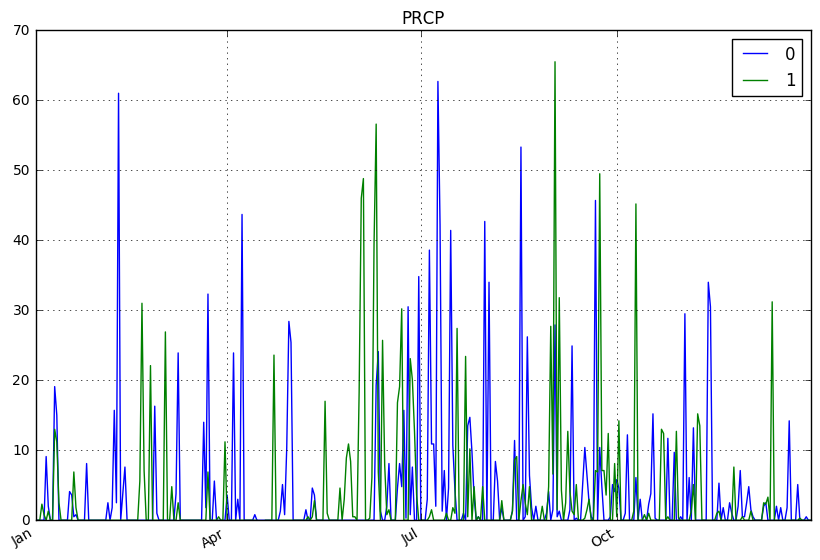

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


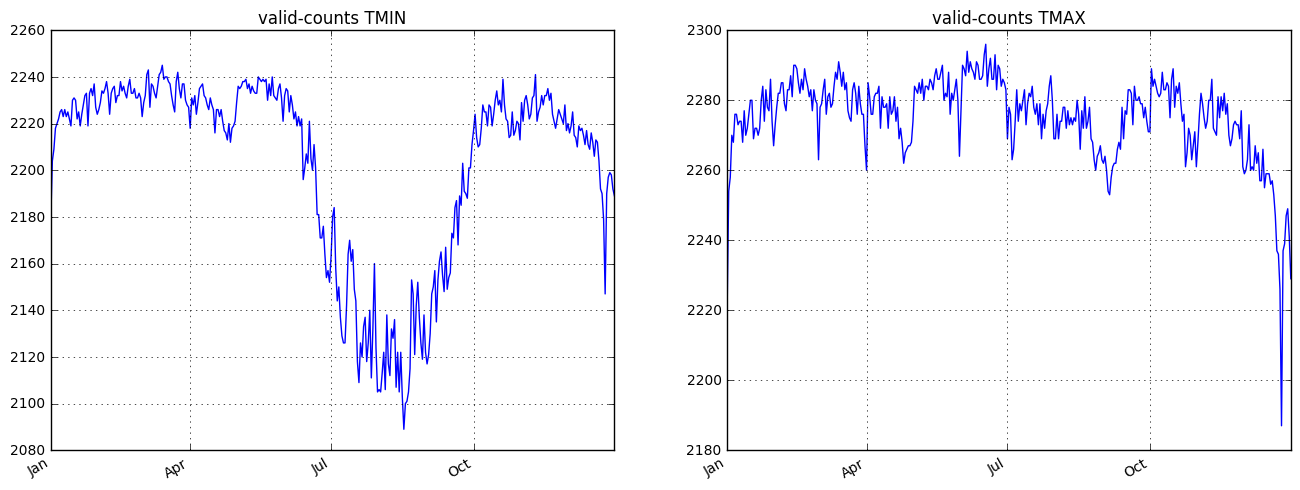

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

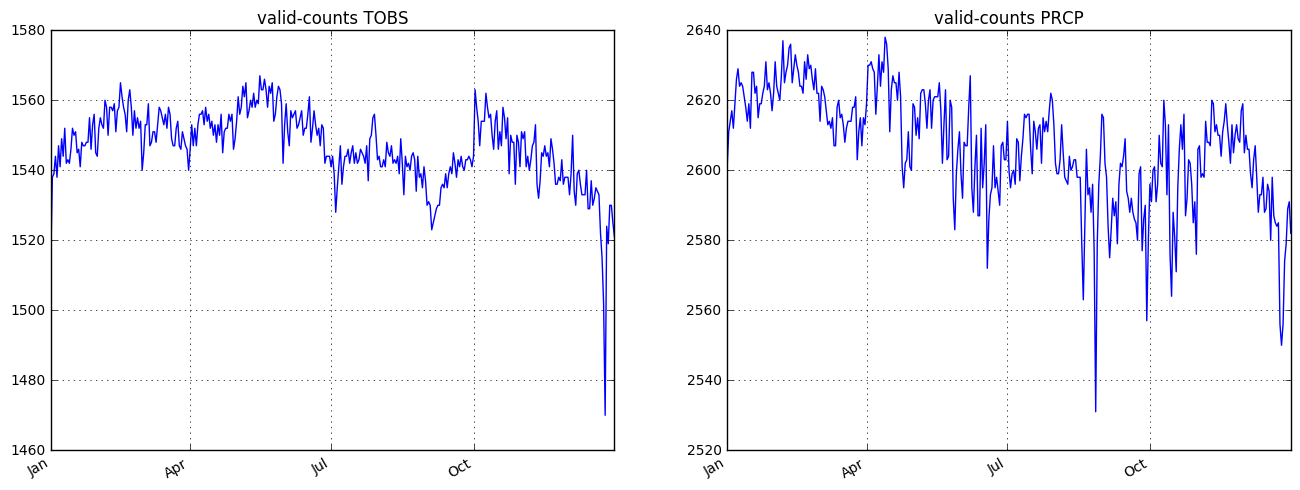

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

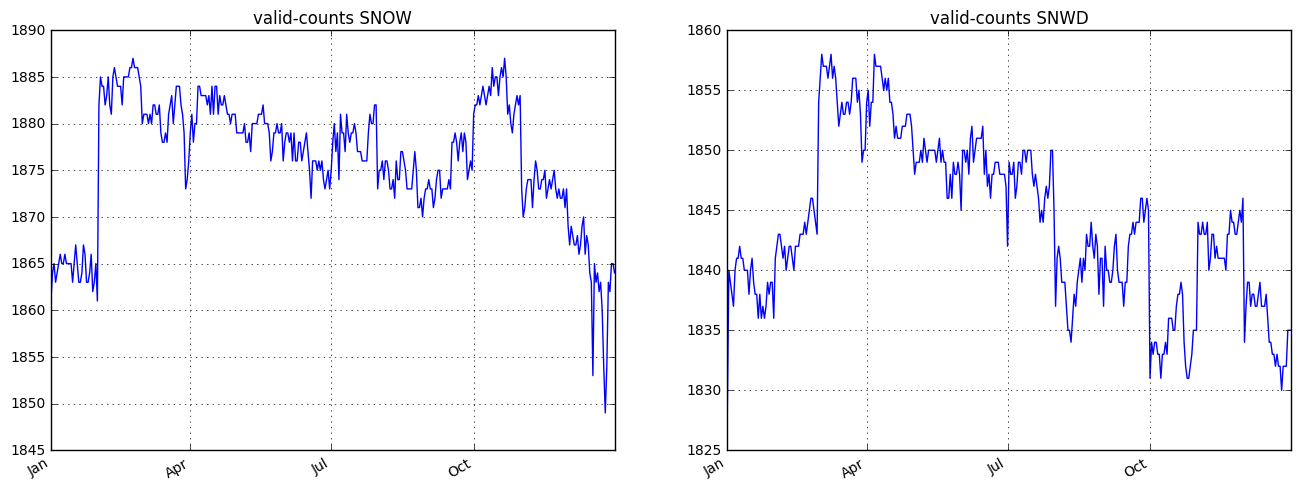

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10.0
    std=np.sqrt(STAT[m]['Var'])/10.0
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

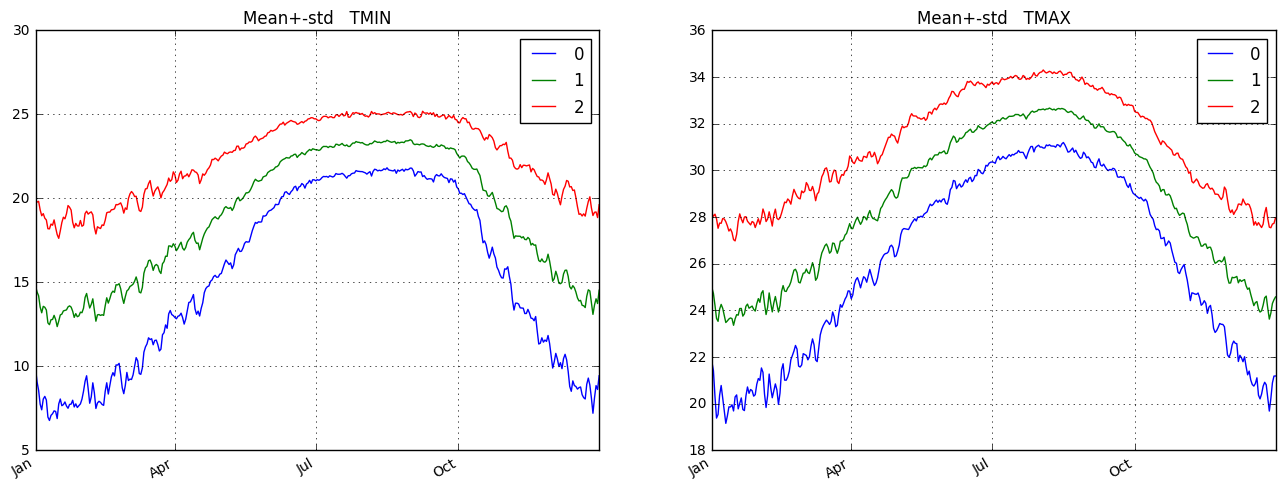

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

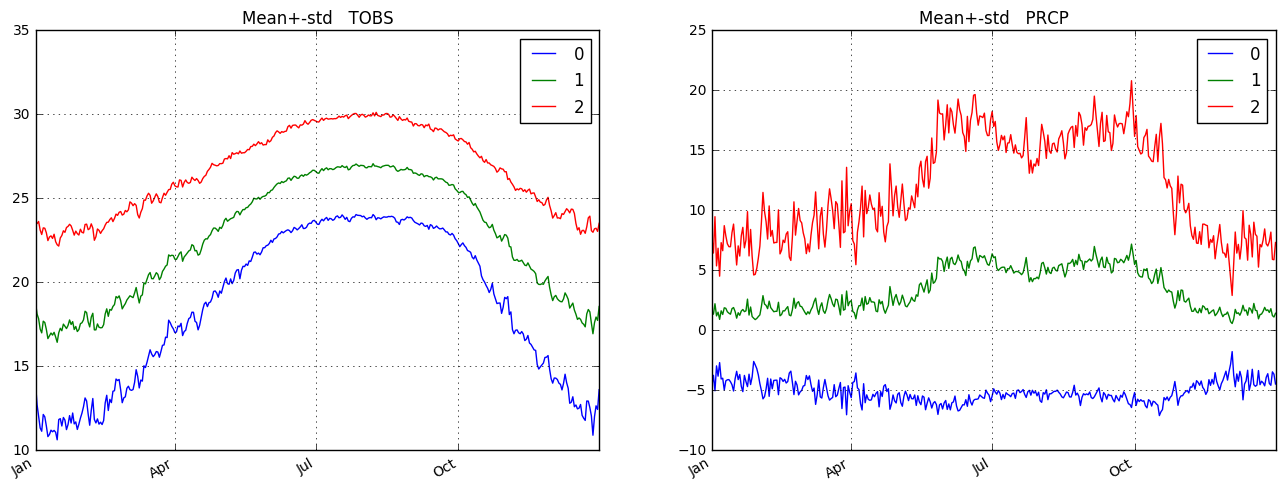

In [11]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

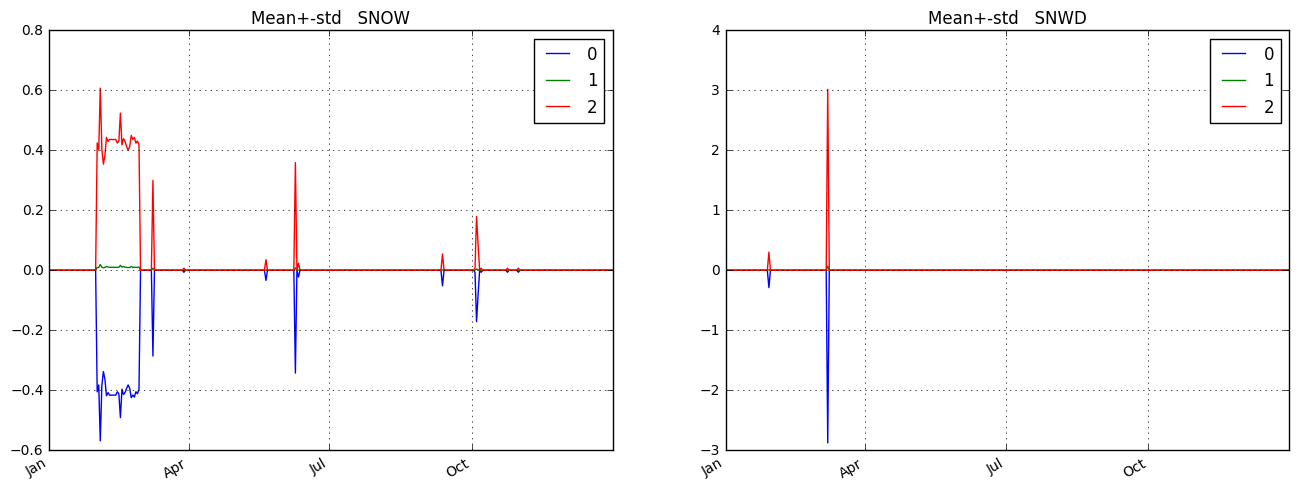

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

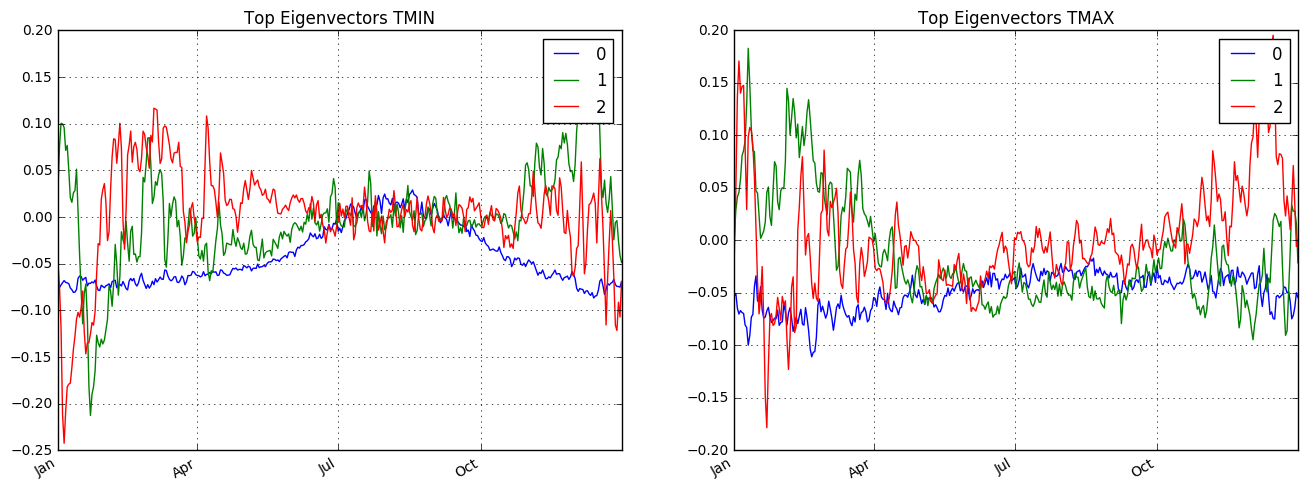

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

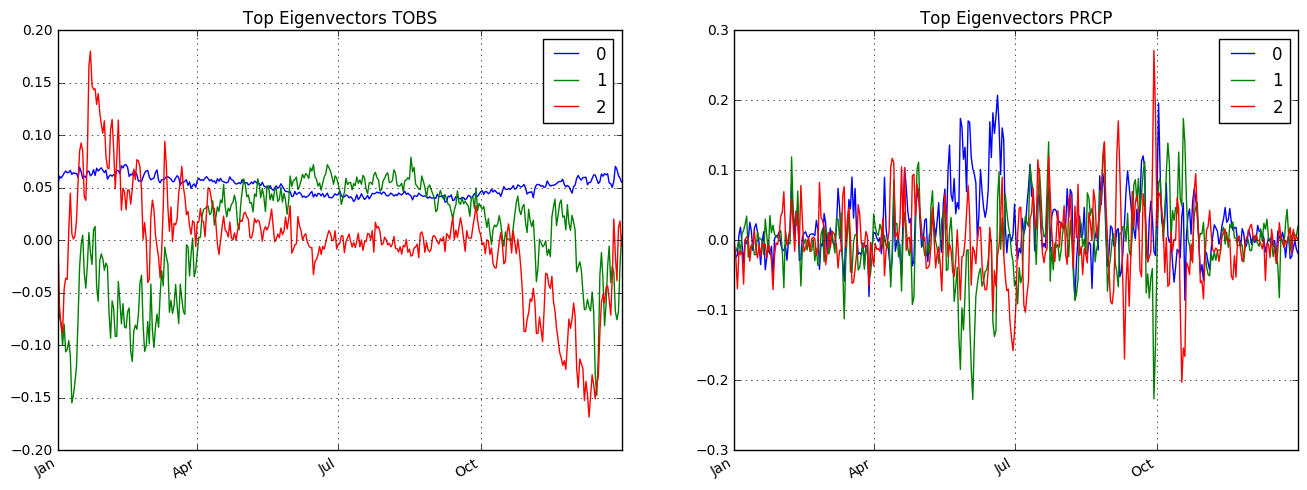

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

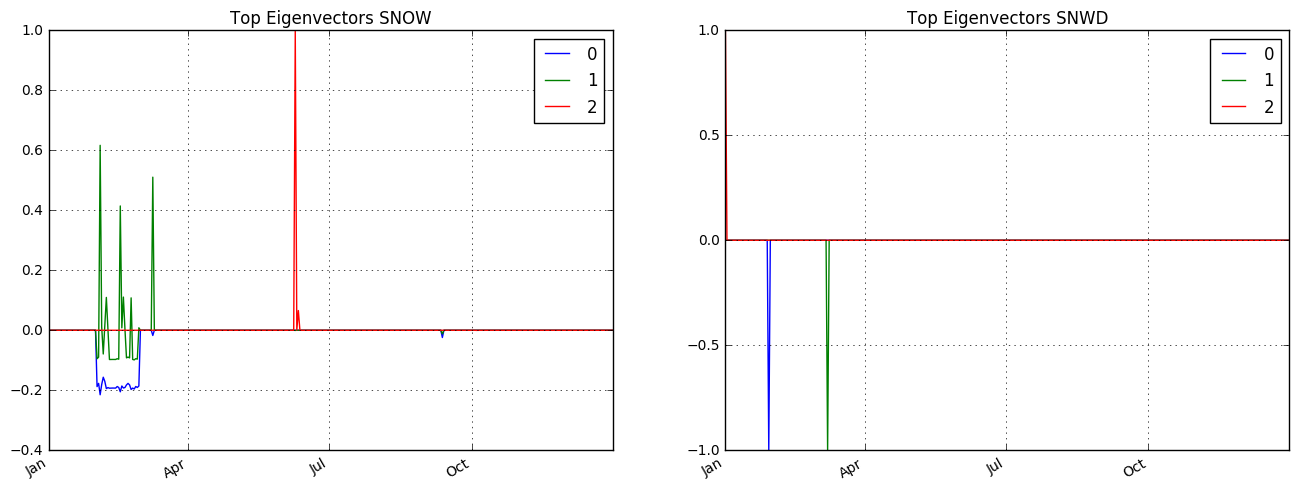

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [17]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

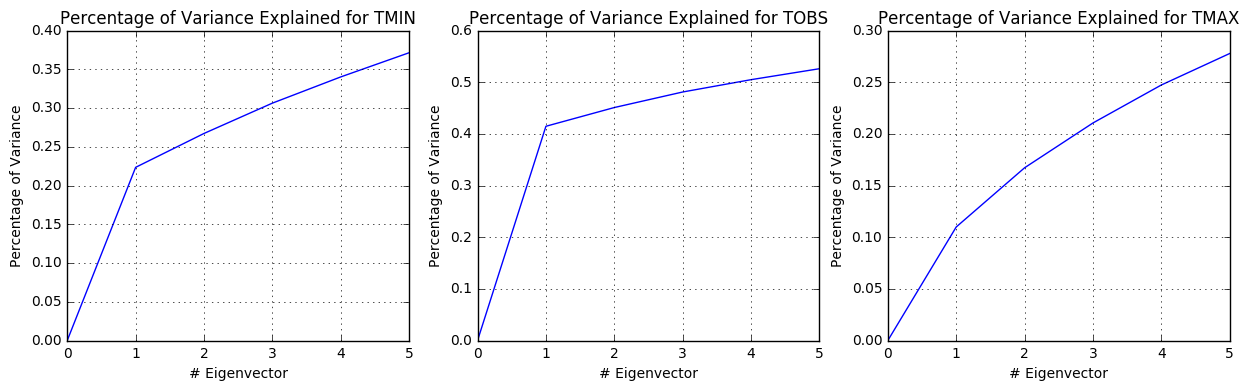

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

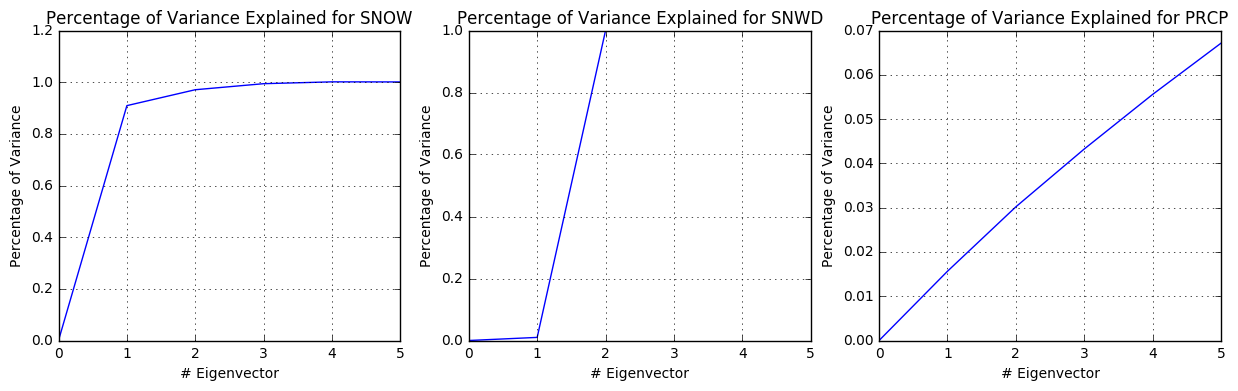

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
#sc.stop()